- boxcox하게되면 큰값으로 쏠림 -> 중간으로 몰고와야함

# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [2]:
from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [7]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

In [8]:
def identity(x):
    return x

class TargetTransform:
    def __init__(self,func='identity'):
        assert func in ['identity','log','sqrt'], \
            print("func must be one of ['identity','log','sqrt']")
        self.func = func
        self.inv_func = {'log':'exp','sqrt':'square'}.get('log','Unknown')
        
        if self.func=='identity':
            self.transform_fn = identity
            self.inverse_transform_fn = identity
        else:
            self.transform_fn = eval('np.{}'.format(self.func))
            self.inverse_transform_fn = eval('np.{}'.format(self.inv_func))
        
    def _get_offset(self,x):
        x = np.array(x)
        if min(x)>0:
            offset = 0
        elif min(x)==0:
            offset = 1e-3
        else:
            offset = -min(x)+1e-3
        return offset
        
    def fit(self,target):
        if self.func=='identity':
            self.offsets = np.zeros(np.array(target).shape[1])
        else:
            self.offsets = []
            for i in range(np.array(target).shape[1]):
                x = np.array(target)[:,i]
                offset = self._get_offset(x)
                self.offsets.append(offset)
    
    def transform(self,target):
        res = []
        for i in range(np.array(target).shape[1]):
            x = np.array(target)[:,i]
            x = self.transform_fn(x+self.offsets[i])
            res.append(x)
        return np.array(res).T
    
    def fit_transform(self,target):
        self.fit(target)
        return self.transform(target)
    
    def inverse_transform(self,target):
        res = []
        for i in range(np.array(target).shape[1]):
            x = np.array(target)[:,i]
            x = self.inverse_transform_fn(x) - self.offsets[i]
            res.append(x)
        return np.array(res).T

<br></br>

# Configuration

In [103]:
class CFG:
    TARGET = ['MLM','HLM']
    SEGMENT = None
    
    # transform
    TARGET_TRANSFORMATION = 'identity'
    
    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Data Load

In [10]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [11]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# EDA

In [12]:
# train_df.describe()

In [13]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [14]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [15]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [16]:
# train_df.nunique()

In [17]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]
    
#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

<br></br>

# Data Preprocess

- [Dacon](https://dacon.io/competitions/official/236127/talkboard/409051?page=1&dtype=recent)에 따르면 100이 넘는 값도 나올 수 있음

In [18]:
# targets = ['MLM','HLM']
# for t in targets:
#     train_df[t] = [0 if x<0 else
#                    100 if x>100 else
#                    x for x in train_df[t]]

<br>

In [19]:
from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [20]:
# 화학구조 이미지 생성
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_df ,'SMILES','Molecule')

In [21]:
# Molecule to MorganFingerprint
def mol2fp(mol):
    radius, nBits = 6, 4096
    #radius, nBits = 2, 512
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=radius, nBits=nBits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [22]:
# FPs column 추가
train_df["FPs"] = train_df.Molecule.apply(mol2fp)
test_df ["FPs"] = test_df .Molecule.apply(mol2fp)

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
feature_select = VarianceThreshold(threshold=0.05)

# 일부사용
tr_fps_selected = feature_select.fit_transform(np.stack(train_df['FPs']))
te_fps_selected = feature_select.transform(np.stack(test_df['FPs']))

# # 전체사용
# tr_fps_selected = np.stack(train_df['FPs'])
# te_fps_selected = np.stack(test_df ['FPs'])

fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]
print(len(fps_names))

train_df = pd.concat([
    train_df.drop('FPs',axis=1),
    pd.DataFrame(tr_fps_selected,columns=fps_names),
],axis=1)

test_df = pd.concat([
    test_df.drop('FPs',axis=1),
    pd.DataFrame(te_fps_selected,columns=fps_names),
],axis=1)

251


In [25]:
# sns.boxplot(train_df[fps_names].std()**2)

In [26]:
# sorted_fps_names = train_df[fps_names].std().sort_values(ascending=False).index.tolist()
# sorted_fps_names = sorted_fps_names[:5]

# # sorted_fps_names = train_df[fps_names].nunique().sort_values(ascending=False).index.tolist()
# # sorted_fps_names = sorted_fps_names[:5]

# for i,col in enumerate(sorted_fps_names):
#     corr_mlm = train_df[[col,'MLM']].corr().values[0,1]
#     corr_hlm = train_df[[col,'HLM']].corr().values[0,1]
    
#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.scatterplot(x=train_df[col],y=train_df['MLM'])
#     plt.grid()
#     plt.title('[MLM] Correlation: {:.4f}'.format(corr_mlm))
#     fig.add_subplot(122)
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.title('[HLM] Correlation: {:.4f}'.format(corr_hlm))
#     plt.suptitle('[{}/{}] {}'.format(i+1,len(sorted_fps_names),col))
#     plt.tight_layout()
#     plt.show()

In [27]:
# col = sorted_fps_names[0]

# plt.figure(figsize=(15,7))
# sns.regplot(x=train_df[col],y=train_df['MLM'])
# plt.grid()
# plt.show()

In [28]:
train_df['fps_raw_avg'] = np.mean(train_df[fps_names].values,axis=1)
test_df ['fps_raw_avg'] = np.mean(test_df [fps_names].values,axis=1)

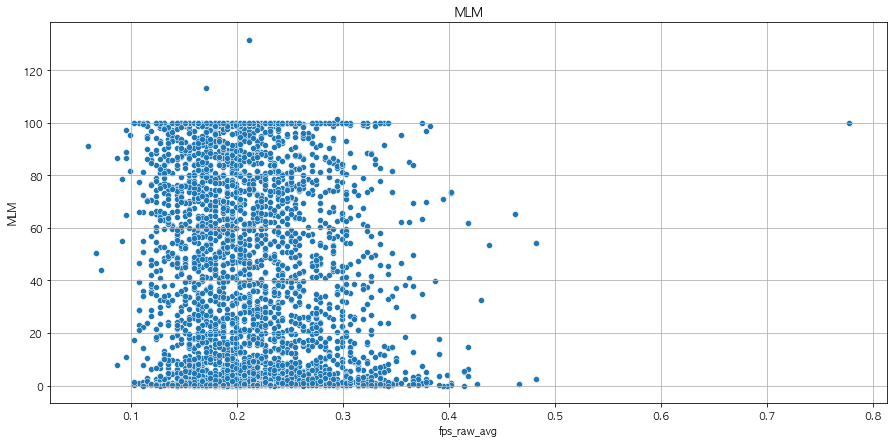

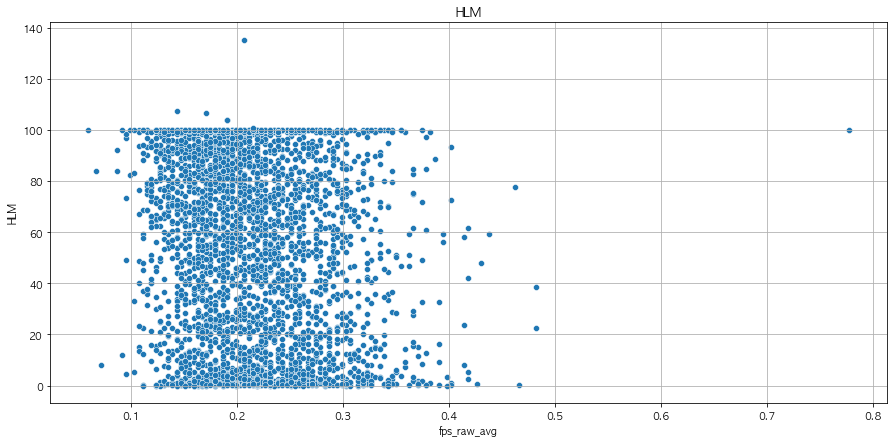

In [29]:
for col in ['MLM','HLM']:
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=train_df['fps_raw_avg'],y=train_df[col])
    plt.grid()
    plt.title(col)
    plt.show()

In [30]:
# fps_dummy_names = []
# for col in fps_names:
#     train_df[f'{col}_dmy'] = np.where(train_df[col]==0,0,1)
#     test_df [f'{col}_dmy'] = np.where(test_df [col]==0,0,1)
#     fps_dummy_names.append(f'{col}_dmy')

In [31]:
# train_df['fps_dummy_sum'] = np.sum(train_df[fps_dummy_names].values,axis=1)
# test_df ['fps_dummy_sum'] = np.sum(test_df [fps_dummy_names].values,axis=1)

In [32]:
# train_df.drop(fps_names,axis=1,inplace=True)
# test_df .drop(fps_names,axis=1,inplace=True)

In [33]:
# 사용할 column만 추출
unuse_features = ['id','SMILES','Molecule']
num_features = [col for col in train_df.columns if col not in unuse_features+CFG.TARGET]

train_df.drop(unuse_features,axis=1,inplace=True)
test_df .drop(unuse_features,axis=1,inplace=True)

In [34]:
train_df.shape

(3498, 261)

In [35]:
train_df.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,fps223,fps224,fps225,fps226,fps227,fps228,fps229,fps230,fps231,fps232,fps233,fps234,fps235,fps236,fps237,fps238,fps239,fps240,fps241,fps242,fps243,fps244,fps245,fps246,fps247,fps248,fps249,fps250,fps251,fps_raw_avg
0,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,0,0,0,0,0,0,0,1,3,0,0,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0.262948
1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,3,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0.155378
2,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0.211155
3,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,7,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,2,0,9,3,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,6,0,1,0,0,0,0,0,0,0,1,0,0,0,6,0,0,0,0,0,0,0,0.

In [36]:
test_df.head()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,fps223,fps224,fps225,fps226,fps227,fps228,fps229,fps230,fps231,fps232,fps233,fps234,fps235,fps236,fps237,fps238,fps239,fps240,fps241,fps242,fps243,fps244,fps245,fps246,fps247,fps248,fps249,fps250,fps251,fps_raw_avg
0,2.641,361.505,4,2,7,2.635,92.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,0,1,0,2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0.183267
1,0.585,370.399,5,0,3,0.585,68.31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,1,1,0,0,2,0,0,0,0,2,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6,2,2,0,0,1,1,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,7,0,0,0,1,0,0,1,0.243028
2,4.276,347.414,4,4,5,4.290,92.86,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2,0,0,4,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,1,4,1,0,0,0,0,0,1,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0.211155
3,1.795,345.358,5,0,2,1.795,81.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,9,0,0,0,0,0,0,0,0.227092
4,1.219,353.418,4,0,2,0.169,61.15,0,0,0,0,0,0,0,0,0,0,0

<br>

## Imputation

In [37]:
def check_null(data):
    d = data.copy()

    null_info = d\
        .isnull().sum()\
        .reset_index()\
        .rename(columns={'index':'feature',0:'null_cnt'})

    null_info = null_info[null_info['null_cnt']!=0]
    null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df)
    null_info = null_info.sort_values('null_cnt',ascending=False).round(2)
    
    return null_info

In [38]:
check_null(train_df)

,feature,null_cnt,null_percentage
2,AlogP,2,0.06


In [39]:
from sklearn.impute import SimpleImputer

impute_columns = ['AlogP']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df[impute_columns] = imputer.fit_transform(train_df[impute_columns])
test_df [impute_columns] = imputer.transform(test_df[impute_columns])

In [40]:
# train_df.drop('AlogP',axis=1,inplace=True)
# test_df .drop('AlogP',axis=1,inplace=True)

In [41]:
check_null(train_df)

,feature,null_cnt,null_percentage


<br>

## Target Transformation

(1) simple transformation (identity / log / sqrt)

In [42]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
train_df[CFG.TARGET] = target_transform.fit_transform(
    target=train_df[CFG.TARGET],
)

In [101]:
# inverse_transform = target_transform.inverse_transform
inverse_transform = None

In [44]:
train_df.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,fps223,fps224,fps225,fps226,fps227,fps228,fps229,fps230,fps231,fps232,fps233,fps234,fps235,fps236,fps237,fps238,fps239,fps240,fps241,fps242,fps243,fps244,fps245,fps246,fps247,fps248,fps249,fps250,fps251,fps_raw_avg
0,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,0,0,0,0,0,0,0,1,3,0,0,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0.262948
1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,3,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0.155378
2,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0.211155
3,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,7,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,2,0,9,3,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,6,0,1,0,0,0,0,0,0,0,1,0,0,0,6,0,0,0,0,0,0,0,0.

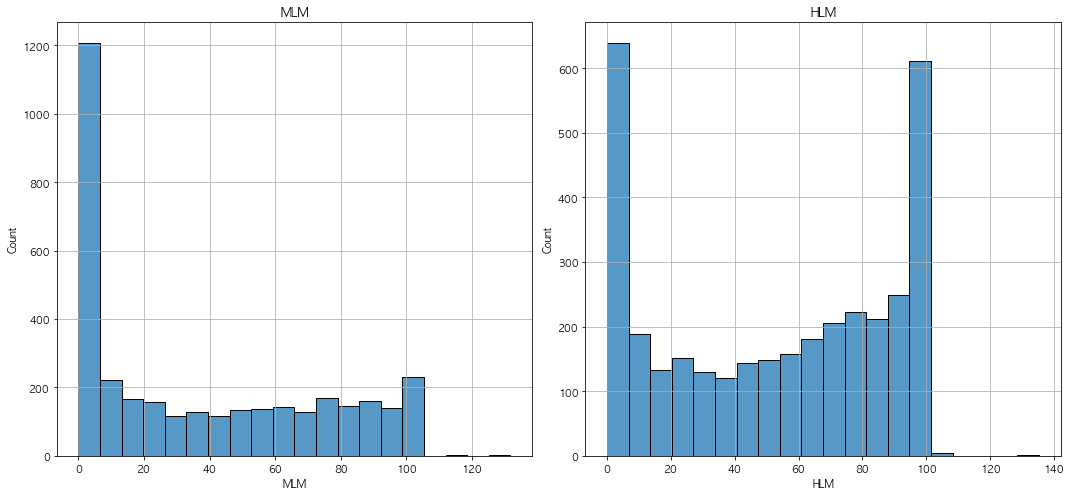

In [45]:
fig = plt.figure(figsize=(15,7))

fig.add_subplot(121)
sns.histplot(train_df['MLM'],bins=20)
plt.title('MLM')
plt.grid()

fig.add_subplot(122)
sns.histplot(train_df['HLM'],bins=20)
plt.title('HLM')
plt.grid()

plt.tight_layout()
plt.show()

(2) boxcox transformation → nan발생함

In [46]:
# from scipy.special import boxcox, inv_boxcox

# def boxcox_transform(x,lam=0.25):
#     return boxcox(x,lam)

# def inverse_boxcox_transform(x,lam=0.25):
#     return inv_boxcox(x,lam)

In [47]:
# inverse_transform = inverse_boxcox_transform

In [48]:
# y = train_df['HLM'].copy()
# y = boxcox_transform(y,0.45)

# print(y.isnull().sum())

# plt.figure(figsize=(15,7))
# plt.hist(y,bins=50)
# plt.grid()
# plt.show()

In [49]:
# for col in CFG.TARGET:
#     train_df[col] = boxcox_transform(train_df[col])

In [50]:
# train_df[CFG.TARGET].isnull().sum()

In [51]:
# inverse_transform(train_df[CFG.TARGET]).isnull().sum()

(3) quantile transformer

In [52]:
# from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer()
# scaled = scaler.fit_transform(train_df[CFG.TARGET])

In [53]:
# inverse_transform = scaler.inverse_transform

In [54]:
# # asis
# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(train_df['MLM'],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(train_df['HLM'],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Asis',fontsize=20)
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(scaled[:,0],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(scaled[:,1],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Tobe',fontsize=20)
# plt.tight_layout()
# plt.show()

In [55]:
# train_df[CFG.TARGET] = scaled

In [56]:
# train_df.head()

(4) sigmoid → nan발생함

In [57]:
# import warnings
# warnings.filterwarnings("ignore")

# from sklearn.preprocessing import MinMaxScaler

# class SigmoidTransformer:
#     def __init__(self):
#         self.minmax_scaler = MinMaxScaler(feature_range=(-5,5))
        
#     def _sigmoid(self,x):
#         return 1 / (1+np.exp(-x))
    
#     def _inv_sigmoid(self,x):
#         return -np.log(1/x-1)

#     def fit(self,x):
#         self.shape = np.array(x).shape
#         y = np.array(x).reshape(-1,self.shape[1])
#         self.minmax_scaler.fit(y)
    
#     def transform(self,x):
#         y = np.array(x).reshape(-1,self.shape[1])
#         y = self.minmax_scaler.transform(x)
#         y = y.reshape(-1,self.shape[1])
#         y = self._sigmoid(y)
#         return y
    
#     def fit_transform(self,x):
#         self.fit(x)
#         return self.transform(x)
    
#     def inverse_transform(self,x):
#         y = np.array(x)
#         y = self._inv_sigmoid(y)
#         y = np.array(y).reshape(-1,self.shape[1])
#         y = self.minmax_scaler.inverse_transform(y)
#         return y

In [58]:
# scaler = SigmoidTransformer()
# scaled = scaler.fit_transform(train_df[CFG.TARGET])

In [59]:
# inverse_transform = scaler.inverse_transform

In [60]:
# # asis
# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(train_df['MLM'],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(train_df['HLM'],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Asis',fontsize=20)
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(scaled[:,0],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(scaled[:,1],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Tobe',fontsize=20)
# plt.tight_layout()
# plt.show()

In [61]:
# train_df[CFG.TARGET] = scaled

In [62]:
train_df[CFG.TARGET].isnull().sum()

MLM    0
HLM    0
dtype: int64

<br>

## Interaction Term

In [63]:
num_features = [col for col in train_df.columns if col not in CFG.TARGET]
len(num_features)

259

In [64]:
# interaction_maker = InteractionTerm()
# interaction_maker.fit(
#     data=train_df,
#     num_features=num_features,
#     corr_cutoff=1,
# )
# train_df = interaction_maker.transform(train_df)
# test_df  = interaction_maker.transform(test_df)

In [65]:
train_df.shape

(3498, 261)

In [66]:
t = 'HLM'

interaction_cols = [col for col in train_df.columns if col.find('*')>=0]
len(interaction_cols)

corr_list = []
for col in interaction_cols:
    corr = train_df[[col,t]].corr().values[0,1]
    corr_list.append([col,np.abs(corr)])
    
corr_df = pd.DataFrame(corr_list,columns=['feature','abs_correlation'])\
    .sort_values('abs_correlation',ascending=False)

In [67]:
for col,corr in corr_df.values[:5]:
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=train_df[col],y=train_df[t])
    plt.grid()
    plt.title('{}: {:.4f}'.format(col,corr))
    plt.show()

<br>

## Memory Reduce

In [68]:
train_df, _ = reduce_mem_usage(train_df,verbose=False)
test_df , _ = reduce_mem_usage(test_df ,verbose=False)

In [69]:
train_df.to_parquet('./out/train_df.parquet')
test_df .to_parquet('./out/test_df.parquet')

<br></br>

# Modeling

## Weighted Ensemble

In [70]:
train_df = pd.read_parquet('./out/train_df.parquet')
test_df = pd.read_parquet('./out/test_df.parquet')

In [71]:
train_fn = train_df.copy()
test_fn  = test_df .copy()

In [72]:
train_fn.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,fps223,fps224,fps225,fps226,fps227,fps228,fps229,fps230,fps231,fps232,fps233,fps234,fps235,fps236,fps237,fps238,fps239,fps240,fps241,fps242,fps243,fps244,fps245,fps246,fps247,fps248,fps249,fps250,fps251,fps_raw_avg
0,26.010000,50.680000,3.259,400.494995,5,2,8,3.259,117.370003,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,0,0,0,0,0,0,0,1,3,0,0,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0.262948
1,29.270000,50.590000,2.169,301.407013,2,1,2,2.172,73.470001,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,3,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0.155378
2,5.586000,80.891998,1.593,297.358002,5,0,3,1.585,62.450001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0.211155
3,5.710000,2.000000,4.771,494.652008,6,0,5,3.475,92.599998,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,7,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,2,0,9,3,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [73]:
# https://stackoverflow.com/questions/66785587/how-do-i-use-validation-sets-on-multioutputregressor-for-xgbregressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.multioutput import MultiOutputRegressor

from sklearn.utils.validation import _check_fit_params
from sklearn.base import is_classifier
from sklearn.utils.fixes import delayed
from joblib import Parallel
from sklearn.multioutput import _fit_estimator

class Evalset_MultiOutputRegressor(MultiOutputRegressor):
    
    def fit(self, X, y, sample_weight=None, **fit_params):
        """ Fit the model to data.
        Fit a separate model for each output variable.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data.
        y : {array-like, sparse matrix} of shape (n_samples, n_outputs)
            Multi-output targets. An indicator matrix turns on multilabel
            estimation.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Only supported if the underlying regressor supports sample
            weights.
        **fit_params : dict of string -> object
            Parameters passed to the ``estimator.fit`` method of each step.
            .. versionadded:: 0.23
        Returns
        -------
        self : object
        """

        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement"
                             " a fit method")

        X, y = self._validate_data(X, y,
                                   force_all_finite=False,
                                   multi_output=True, accept_sparse=True)

        if is_classifier(self):
            check_classification_targets(y)

        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for "
                             "multi-output regression but has only one.")

        if (sample_weight is not None and
                not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support"
                             " sample weights.")

        fit_params_validated = _check_fit_params(X, fit_params)
        [(X_test, Y_test)] = fit_params_validated.pop('eval_set')
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_estimator)(
                self.estimator, X, y[:, i], sample_weight,
                **fit_params_validated, eval_set=[(X_test, Y_test[:, i])]) #.iloc로 수정
            for i in range(y.shape[1]))
        return self

In [159]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,hyperparameters,weight=['equal','balanced'],inverse_transform=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self._get_regressors()
    
    def _get_regressors(self):
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : -1,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'reg:squarederror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
    
        params_lightgbm = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            #'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations']//10,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : -1,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE',
            'eval_metric': 'RMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE',
            'eval_metric': 'RMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE',
            'eval_metric': 'RMSE',
            'grow_policy' : 'Lossguide',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 5,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE',
            'eval_metric': 'RMSE',
            'grow_policy' : 'Depthwise',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost5 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE',
            'eval_metric': 'RMSE',
            'grow_policy' : 'Depthwise',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost6 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE',
            'eval_metric': 'RMSE',
            'grow_policy' : 'Depthwise',
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 5,
        }
        
        self.regressors = [
            #MultiOutputRegressor(LinearRegression()),
            #MultiOutputRegressor(RidgeCV(**params_ridge)),
            #MultiOutputRegressor(LassoCV(**params_lasso)),
            MultiOutputRegressor(ElasticNetCV(**params_elasticnet)),
            Evalset_MultiOutputRegressor(XGBRegressor(**params_xgboost)),
            Evalset_MultiOutputRegressor(LGBMRegressor(**params_lightgbm)),
            MultiOutputRegressor(ExtraTreesRegressor(**params_extratrees)),
            CatBoostRegressor(**params_catboost1),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            CatBoostRegressor(**params_catboost5),
            CatBoostRegressor(**params_catboost6),
        ]
        self.regressors_name = [
            #'OLS',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            'XGBoost',
            'LightGBM',
            'ExtraTrees',
            'CatBoost1',
            'CatBoost2',
            'CatBoost3',
            'CatBoost4',
            'CatBoost5',
            'CatBoost6',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        #pred = pred.reshape(len(pred)//2,2)
        return pred

    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        #pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def _set_0to100(self,pred):
        pred = np.array(pred).flatten()
        if np.where((pred<0)|(pred>100),1,0).sum()>0:
            pred = [0 if x<0 else
                    100 if x>100 else
                    x for x in pred]
        pred = np.array(pred).flatten()
        #pred = pred.reshape(len(pred)//2,2)
        return pred
    
    def _rescale_0to100(self,pred,minmax=None):
        pred = np.array(pred)
        
        if minmax is None:
            _min = pred.min(axis=0)
            _max = pred.max(axis=0)
        else:
            _min, _max = minmax
        
        pred = (pred - _min) / (_max-_min)
        pred = 100*pred
        
        return pred, (_min,_max)
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        self.features = X.columns
        self.oh_features = X_oh.columns
        
        tr_true = np.array(y)
        va_true = np.array(y_val)
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        self.minimum_value = 0   #min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = 100 #max(np.nanmax(y),np.nanmax(y_val))
        
        self.cat_features = cat_features
        self.scores = []
        self.weights = []
        self.fitting_elapsed = []
        self.minmax_list = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
            
            if verbose:
                pbar.set_description(name)
                
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('CatBoost')>=0:
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=self.hyperparameters['iterations']//50,
                    #verbose=True,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                fit_params = {
                    'eval_set':[(X_val_oh.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_oh.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                fit_params = {
                    'eval_set':[(X_val_tmp.values,y_val.values)],
                    'early_stopping_rounds':self.hyperparameters['early_stopping_rounds'],
                    'verbose':0,
                }
                regressor.fit(
                    X_tmp.values,y.values,
                    **fit_params,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh.values,y.values)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_pred = np.array(tr_pred)
            va_pred = np.array(va_pred)
            
            #tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            #va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
                
            tr_pred = self._set_0to100(tr_pred)
            va_pred = self._set_0to100(va_pred)
            
            tr_pred, minmax = self._rescale_0to100(tr_pred,minmax=None)
            va_pred, _      = self._rescale_0to100(va_pred,minmax=minmax)
            
            # global _tr_pred, _va_pred, _tr_true, _va_true
            # _tr_pred,_va_pred = tr_pred,va_pred
            # _tr_true,_va_true = tr_true,va_true
            
            tr_score = mean_squared_error(y_true=tr_true,y_pred=tr_pred)**0.5
            va_score = mean_squared_error(y_true=va_true,y_pred=va_pred)**0.5
            
            # tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
            # tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
            # va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
            # va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
            # tr_score = 0.5*tr_score_1+0.5*tr_score_2
            # va_score = 0.5*va_score_1+0.5*va_score_2
            
            e = time.time()
            self.scores.append(va_score)
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            self.minmax_list.append(minmax)
            
            blank = ' '*(11-len(regressor_name))
            fit_iter_str = str(fit_iter).zfill(len(str(len(self.regressors))))
            fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                .format(fit_iter_str,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
            print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = mean_squared_error(y_true=tr_true,y_pred=tr_pred)**0.5
        ens_va_score = mean_squared_error(y_true=va_true,y_pred=va_pred)**0.5
        
        # tr_score_1 = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
        # tr_score_2 = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
        # va_score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
        # va_score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
        # ens_tr_score = 0.5*tr_score_1+0.5*tr_score_2
        # ens_va_score = 0.5*va_score_1+0.5*va_score_2
        
        ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
            .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
        print(ens_fit_progress)
        
        self.ensemble_score = ens_va_score
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor,minmax in zip(self.regressors_name,self.regressors,self.minmax_list):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            #y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            y_pred = self._set_0to100(y_pred)
            y_pred, _ = self._rescale_0to100(y_pred,minmax=minmax)
            
            pred_list.append(y_pred)
            
        final_pred = []
        for pred,weight in zip(pred_list,self.weights):
            pred = np.array(pred).flatten()
            pred = np.array(pred)*weight
            #pred = pred.reshape(len(pred)//2,2)
            final_pred.append(pred)
        final_pred = np.sum(final_pred,axis=0)
            
        if self.inverse_transform is not None:
            final_pred = self.inverse_transform(np.array(final_pred))
            final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
            
        #final_pred = self._set_0to100(final_pred)
            
        return final_pred
    
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'scores' : self.scores,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'ensemble_score' : self.ensemble_score,
            'minmax_list' : self.minmax_list,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.scores = save_dict['scores']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.ensemble_score = save_dict['ensemble_score']
            self.minmax_list = save_dict['minmax_list']

In [160]:
def load_model(hyperparameters,path):
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    ensemble_model.load_model(path)
    return ensemble_model

In [161]:
def multi_rmse(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse_list = []
    for i in range(y_true.shape[1]):
        rmse = mean_squared_error(y_true=y_true[:,i],y_pred=y_pred[:,i])**0.5
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

In [162]:
def set_0to100(x):
    x = np.array(x)
    return [0 if _x<0 else
            100 if _x>100 else
            _x for _x in x]

In [163]:
from sklearn.model_selection import KFold

In [172]:
hyperparameters = {
    'max_depth' : 9,
    'random_state' : 0,
    'learning_rate' : 0.01,
    'iterations' : 20000,
    'early_stopping_rounds' : 300,
}

In [173]:
target = CFG.TARGET[0]
print(target)

MLM


In [174]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[target]

# unique인 컬럼 제외
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)
    print('deleted:',len(unique_cols))

In [175]:
# cat_features = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# X     [cat_features] = X     [cat_features].astype(str)
# X_test[cat_features] = X_test[cat_features].astype(str)

In [176]:
X.shape

(3498, 259)

In [177]:
gc_collect_all()

gc_collect: 15593


----------------------------------------------------------------------------------------------------
> [K-Fold] 1/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=18.325, val_loss=31.052, elasped=28.7s
[2/6] CatBoost2  : loss=19.057, val_loss=31.240, elasped=31.8s
[3/6] CatBoost3  : loss=18.018, val_loss=31.079, elasped=41.9s
[4/6] CatBoost4  : loss=14.420, val_loss=30.932, elasped=51.9s
[5/6] CatBoost5  : loss=17.115, val_loss=31.181, elasped=47.5s
[6/6] CatBoost6  : loss=16.687, val_loss=31.035, elasped=64.5s
<Weighted Ensemble(weight='balanced')> loss=17.221, val_loss=31.038, elasped=266.3s


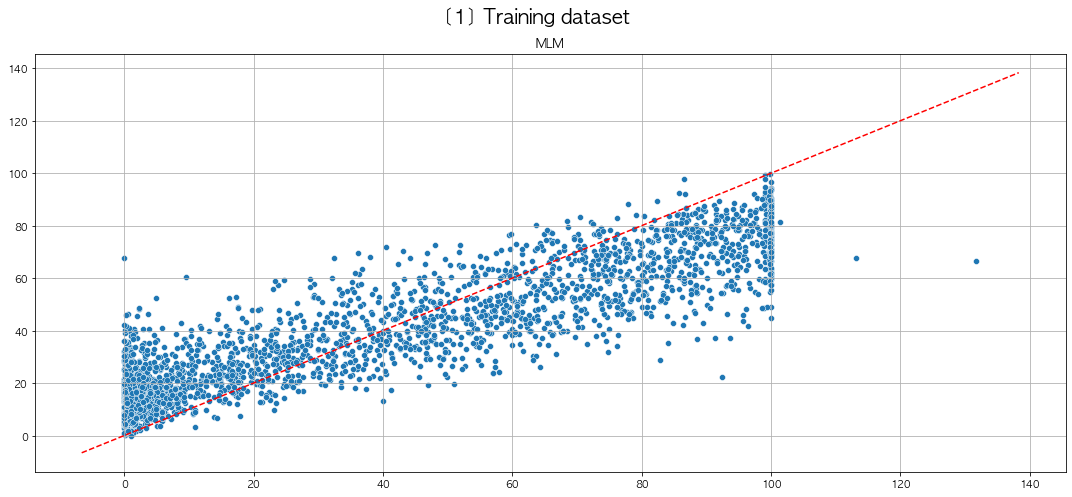

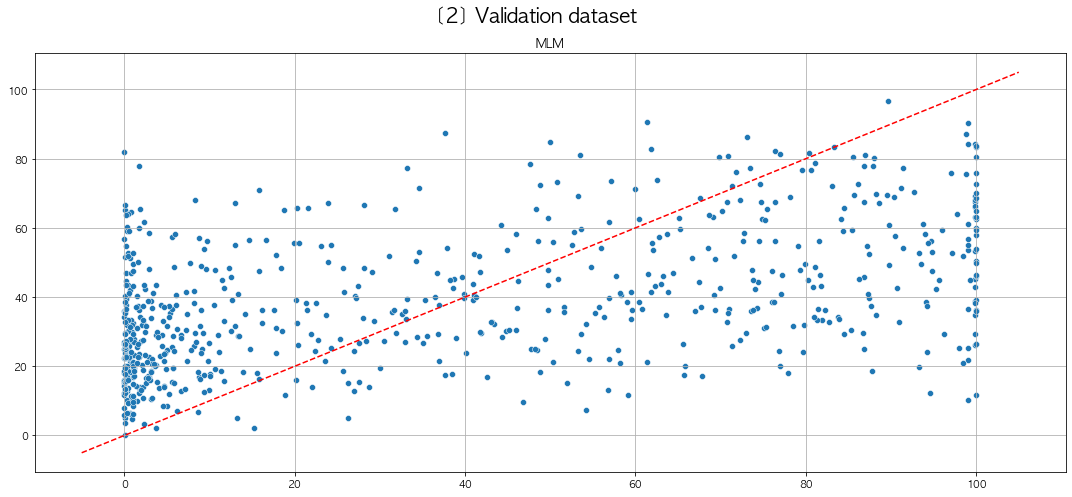

----------------------------------------------------------------------------------------------------
> [K-Fold] 2/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=21.841, val_loss=31.724, elasped=20.7s
[2/6] CatBoost2  : loss=21.273, val_loss=31.784, elasped=25.0s
[3/6] CatBoost3  : loss=22.346, val_loss=31.725, elasped=24.1s
[4/6] CatBoost4  : loss=19.644, val_loss=31.664, elasped=30.6s
[5/6] CatBoost5  : loss=21.887, val_loss=31.668, elasped=27.0s
[6/6] CatBoost6  : loss=20.225, val_loss=31.656, elasped=40.8s
<Weighted Ensemble(weight='balanced')> loss=21.160, val_loss=31.664, elasped=168.3s


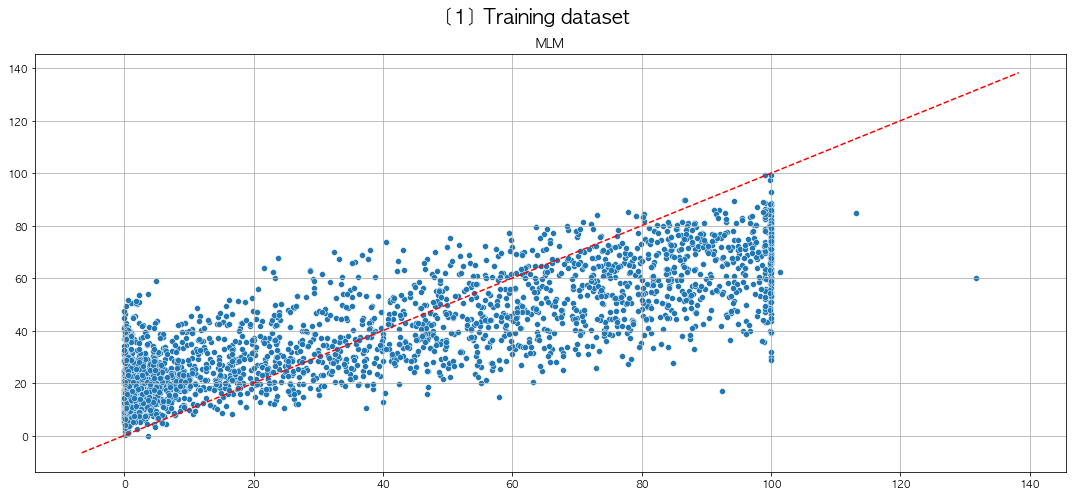

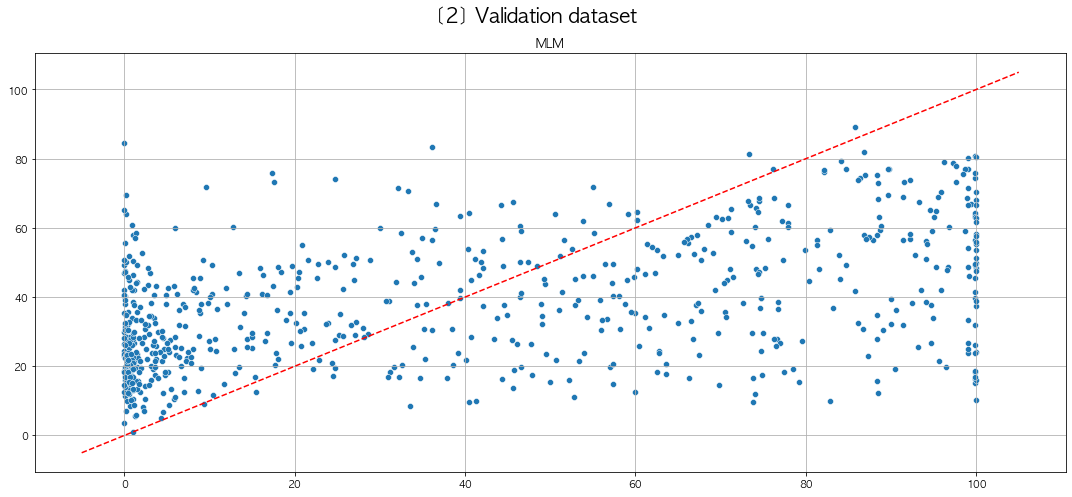

----------------------------------------------------------------------------------------------------
> [K-Fold] 3/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=20.381, val_loss=29.047, elasped=28.9s
[2/6] CatBoost2  : loss=19.512, val_loss=29.072, elasped=38.6s
[3/6] CatBoost3  : loss=20.815, val_loss=29.109, elasped=32.3s
[4/6] CatBoost4  : loss=15.082, val_loss=29.071, elasped=49.5s
[5/6] CatBoost5  : loss=19.666, val_loss=29.165, elasped=38.4s
[6/6] CatBoost6  : loss=19.134, val_loss=29.126, elasped=50.7s
<Weighted Ensemble(weight='balanced')> loss=19.042, val_loss=29.047, elasped=238.4s


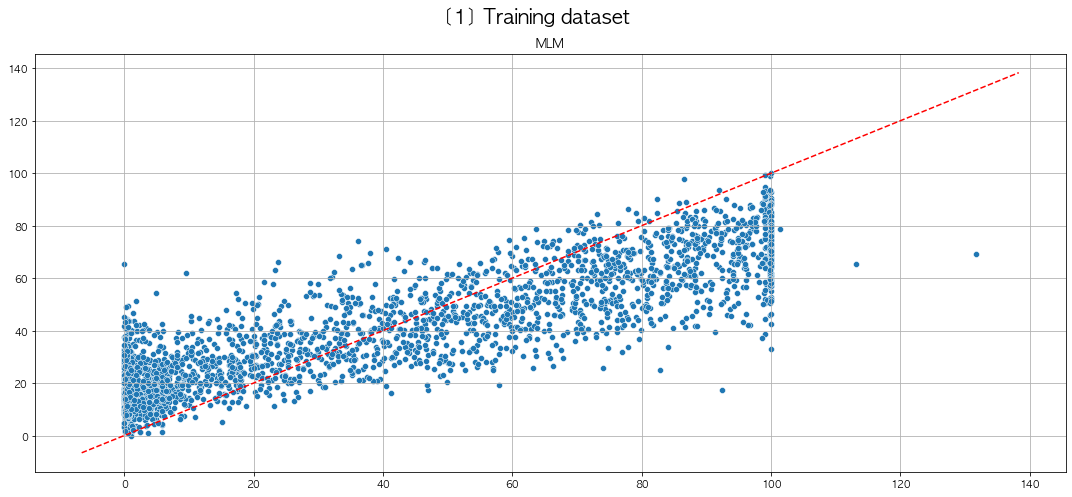

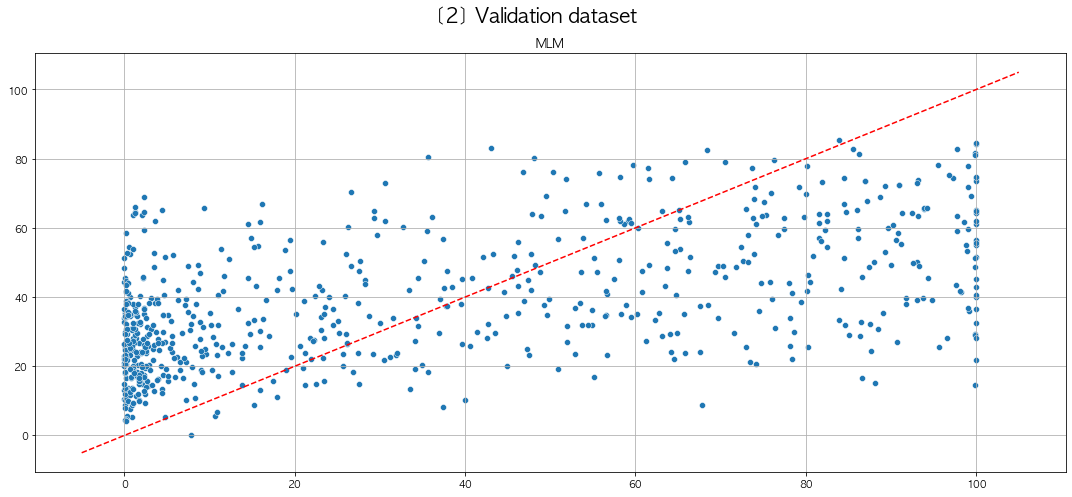

----------------------------------------------------------------------------------------------------
> [K-Fold] 4/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=22.385, val_loss=30.468, elasped=21.1s
[2/6] CatBoost2  : loss=22.938, val_loss=30.374, elasped=20.8s
[3/6] CatBoost3  : loss=22.746, val_loss=30.384, elasped=24.3s
[4/6] CatBoost4  : loss=17.509, val_loss=30.307, elasped=37.1s
[5/6] CatBoost5  : loss=21.412, val_loss=30.238, elasped=31.3s
[6/6] CatBoost6  : loss=21.293, val_loss=30.163, elasped=39.6s
<Weighted Ensemble(weight='balanced')> loss=21.329, val_loss=30.278, elasped=174.3s


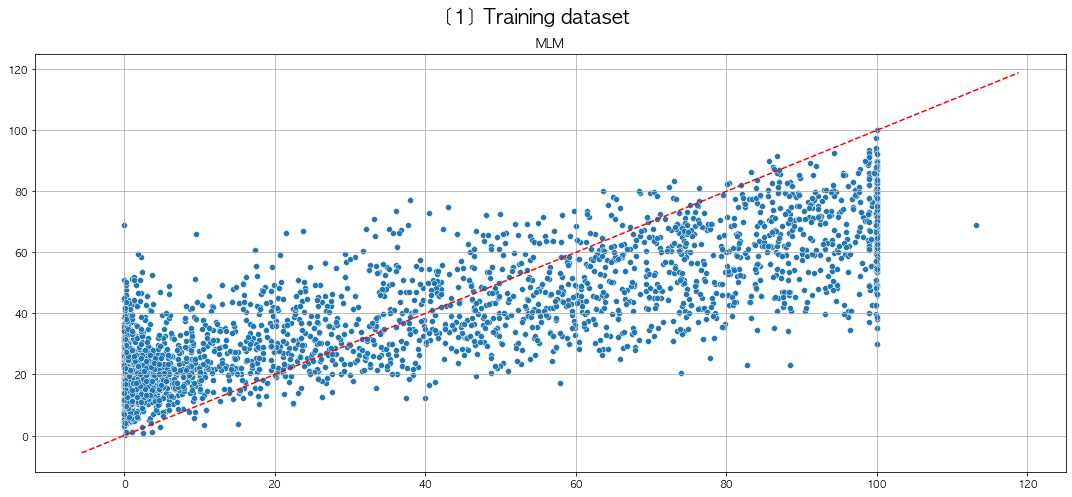

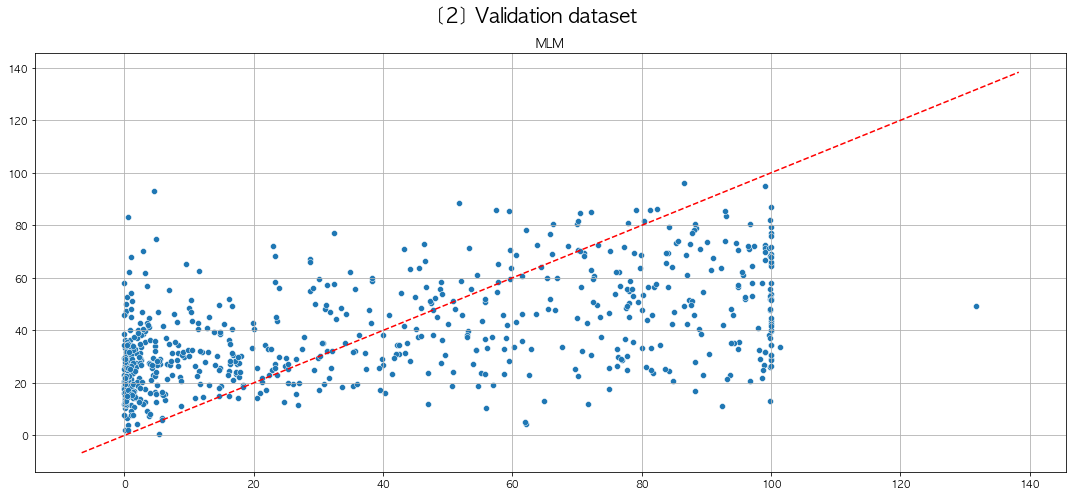

----------------------------------------------------------------------------------------------------
> [K-Fold] 5/5
----------------------------------------------------------------------------------------------------
[1/6] CatBoost1  : loss=24.177, val_loss=29.727, elasped=15.5s
[2/6] CatBoost2  : loss=24.834, val_loss=29.818, elasped=15.5s
[3/6] CatBoost3  : loss=25.741, val_loss=29.932, elasped=14.7s
[4/6] CatBoost4  : loss=21.206, val_loss=29.739, elasped=24.9s
[5/6] CatBoost5  : loss=21.681, val_loss=29.728, elasped=29.7s
[6/6] CatBoost6  : loss=22.297, val_loss=29.740, elasped=29.1s
<Weighted Ensemble(weight='balanced')> loss=23.251, val_loss=29.721, elasped=129.3s


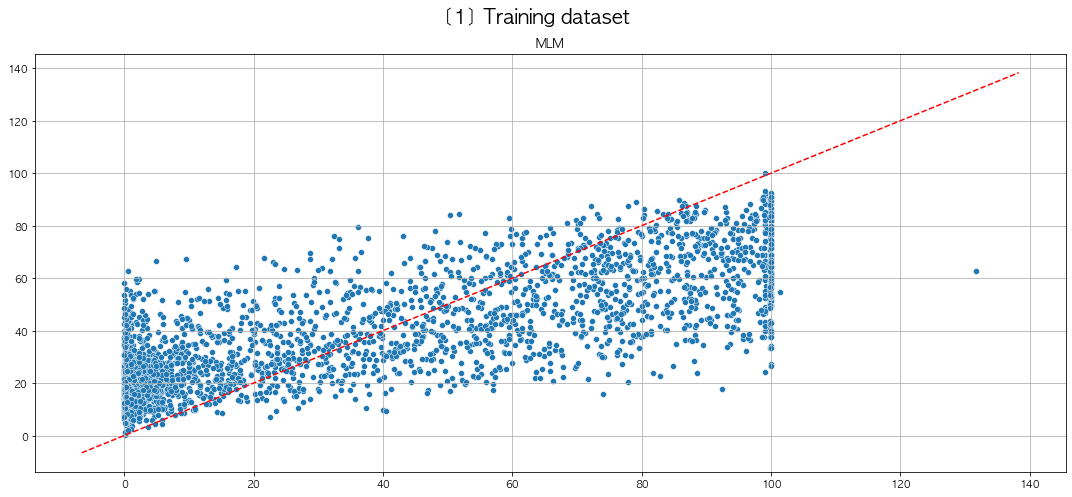

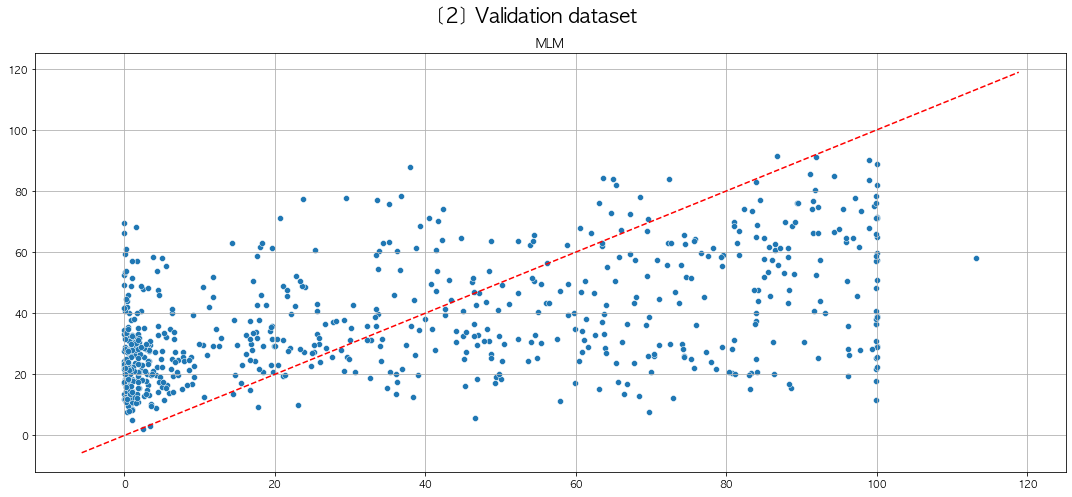

CPU times: user 47min 35s, sys: 7min 7s, total: 54min 42s
Wall time: 16min 20s


In [178]:
%%time

save_path = './mc/kf_weiens_catall/{}_k{}.pickle'
gc_collect_all(verbose=False)

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

models = []
scores = []
k=0
for tr_idx,val_idx in kf.split(X,y):
    k+=1
    
    print('-'*100)
    print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
    print('-'*100)
    
    # kfold dataset
    X_tr, X_va = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

    # define the model
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    # cat만 가져오기
    ensemble_model.regressors = ensemble_model.regressors[-6:]
    ensemble_model.regressors_name = ensemble_model.regressors_name[-6:]

    # fit the model
    ensemble_model.fit(
        X_tr,y_tr,
        eval_set=[(X_va,y_va)],
        oh_set=[(X_tr,X_va)],
        cat_features=[],
        verbose=0,
    )

    # save the model
    ensemble_model.save_model(save_path.format(target,k))
    tr_pred = ensemble_model.predict(X_tr,X_tr)
    va_pred = ensemble_model.predict(X_va,X_va)
    
    if inverse_transform is not None:
        tr_true = inverse_transform(y_tr)
        va_true = inverse_transform(y_va)
    else:
        tr_true = np.array(y_tr)
        va_true = np.array(y_va)

    # train
    fig = plt.figure(figsize=(15,7))
    sns.scatterplot(x=tr_true,y=tr_pred)
    abline(0,1)
    plt.grid()
    plt.title(target)
    plt.suptitle('[1] Training dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # validation
    fig = plt.figure(figsize=(15,7))
    sns.scatterplot(x=va_true,y=va_pred)
    abline(0,1)
    plt.grid()
    plt.title(target)
    plt.suptitle('[2] Validation dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # caculate score
    score = mean_squared_error(y_true=va_true,y_pred=va_pred)**0.5

    # append inner loop
    models.append(ensemble_model)
    scores.append([k,len(X_tr),len(X_va),score])

In [179]:
# !!!inverse boxcox 후, prediction에 Null이 생기는 경우에는 어떻게할지?

In [180]:
# def func(x):
#     upper = 70
#     offset=0.1
#     new_x = [min(100,v*(1+offset)) if v>=upper else
#              max(0,v*(1-offset)) if v<=(100-upper) else
#              v for v in x]
#     return np.array(new_x)

In [181]:
# i=0
# asis = mean_squared_error(y_pred=va_pred[:,i],y_true=va_true[:,i])**0.5
# tobe = mean_squared_error(y_pred=func(va_pred[:,i]),y_true=va_true[:,i])**0.5
# asis,tobe

In [182]:
# plt.figure(figsize=(15,7))
# sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
# abline(0,1)
# plt.grid()
# plt.show()

# plt.figure(figsize=(15,7))
# sns.scatterplot(x=va_true[:,0],y=func(va_pred[:,0]))
# abline(0,1)
# plt.grid()
# plt.show()

In [183]:
score_df = pd.DataFrame(scores,columns=['k','n_train','n_val','rmse'])
score_df

,k,n_train,n_val,rmse
0,1,2798,700,31.038458
1,2,2798,700,31.664176
2,3,2798,700,29.047267
3,4,2799,699,30.278186
4,5,2799,699,29.720809


In [184]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

In [185]:
# cat_features = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# X     [cat_features] = X     [cat_features].astype(str)
# X_test[cat_features] = X_test[cat_features].astype(str)

In [187]:
path = './mc/kf_weiens_catall/{}_k{}.pickle'
model_list = [load_model(hyperparameters,path.format(target,k)) for k in range(1,6)]

features = model_list[0].features
oh_features = model_list[0].oh_features

tr_pred = np.mean([model.predict(X[features],X[oh_features]) for model in model_list],axis=0)
tr_pred = pd.DataFrame(tr_pred,index=X.index)

te_pred = np.mean([model.predict(X_test[features],X_test[oh_features]) for model in model_list],axis=0)
te_pred = pd.DataFrame(te_pred,index=X_test.index)

In [188]:
# tr_pred = tr_pred.apply(set_0to100)
# te_pred = pd.DataFrame(target_transform.inverse_transform(y)).apply(set_0to100)

In [202]:
if inverse_transform is not None:
    y_new = inverse_transform(y[target])
else:
    y_new = np.array(y[target])

In [204]:
mean_squared_error(y_true=tr_pred,y_pred=y_new)**0.5

22.147177510165935

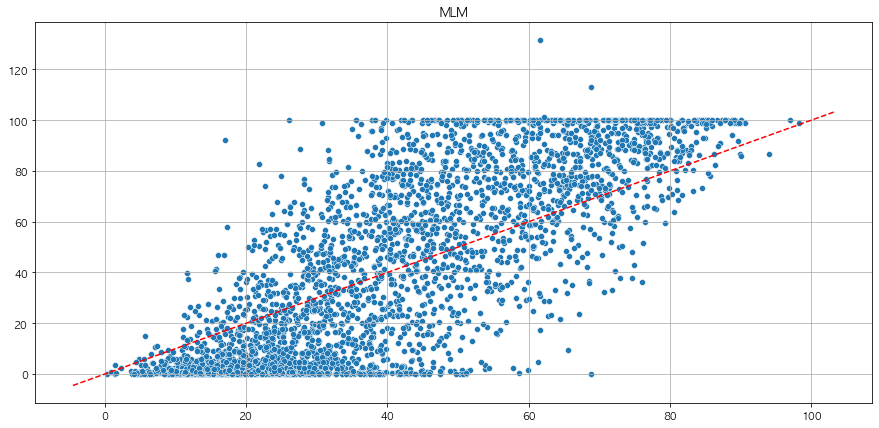

In [215]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=np.array(tr_pred).flatten(),y=y_new)
abline(0,1)
plt.grid()
plt.title('MLM')
plt.show()

# plt.figure(figsize=(15,7))
# sns.scatterplot(x=tr_pred.iloc[:,1],y=y_new[:,1])
# abline(0,1)
# plt.grid()
# plt.title('HLM')
# plt.show()

In [220]:
te_pred.shape, submit.shape

((483, 1), (483, 3))

In [221]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[target] = np.array(te_pred)

In [222]:
submit.tail()

,id,MLM,HLM
478,TEST_478,14.881697,0
479,TEST_479,82.313373,0
480,TEST_480,39.308032,0
481,TEST_481,62.821983,0
482,TEST_482,33.697771,0


In [ ]:
# public :  (identity)
submit.to_csv('./out/15_weiens_seg_catall_set0to100_kf10.csv',index=False)

<br>

## Stacking

In [ ]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

# unique인 컬럼 제외
# (1) X
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)

In [ ]:
org_path = './mc/kf_weiens_catall/k{}.pickle'
model_list = [load_model(hyperparameters,org_path.format(k)) for k in range(1,6)]

features    = model_list[0].features
oh_features = model_list[0].oh_features
X = X[features]
X_test = X_test[features]

tr_pred = pd.DataFrame(index=X.index)
te_pred = pd.DataFrame(index=X_test.index)

tr_pred[['pred1','pred2']] = np.mean([model.predict(X     ,X     ) for i,model in enumerate(model_list,1)],axis=0)
te_pred[['pred1','pred2']] = np.mean([model.predict(X_test,X_test) for i,model in enumerate(model_list,1)],axis=0)

# for i,model in enumerate(model_list,1):
#     tr_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X,X)
#     te_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X_test,X_test)

X_new      = pd.concat([X      ,tr_pred],axis=1)
X_test_new = pd.concat([X_test ,te_pred],axis=1)

In [ ]:
%%time

save_path = './mc/kf_weiens_catall/stacking_k{}.pickle'

gc_collect_all(verbose=False)

models = []
scores = []
k=0
for tr_idx,val_idx in kf.split(X,y):
    k+=1
    
    print('-'*100)
    print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
    print('-'*100)
    
    # kfold dataset
    X_tr, X_va = X_new.iloc[tr_idx], X_new.iloc[val_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

    # define the model
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=inverse_transform,
    )
    # cat만 가져오기
    ensemble_model.regressors = ensemble_model.regressors[-6:]
    ensemble_model.regressors_name = ensemble_model.regressors_name[-6:]

    # fit the model
    ensemble_model.fit(
        X_tr,y_tr,
        eval_set=[(X_va,y_va)],
        oh_set=[(X_tr,X_va)],
        cat_features=[],
        verbose=0,
    )

    # save the model
    ensemble_model.save_model(save_path.format(k))
    tr_pred = ensemble_model.predict(X_tr,X_tr)
    va_pred = ensemble_model.predict(X_va,X_va)

    if inverse_transform is not None:
        tr_true = inverse_transform(y_tr)
        va_true = inverse_transform(y_va)
    else:
        tr_true = np.array(y_tr)
        va_true = np.array(y_va)

    # train
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[1] Training dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # validation
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(121)
    sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[0])
    fig.add_subplot(122)
    sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
    abline(0,1)
    plt.grid()
    plt.title(CFG.TARGET[1])
    plt.suptitle('[2] Validation dataset',fontsize=20)
    plt.tight_layout()
    plt.show()

    # caculate score
    score_1 = mean_squared_error(y_true=va_true[:,0],y_pred=va_pred[:,0])**0.5
    score_2 = mean_squared_error(y_true=va_true[:,1],y_pred=va_pred[:,1])**0.5
    score = 0.5*score_1+0.5*score_2

    # append inner loop
    models.append(ensemble_model)
    scores.append([k,len(X_tr),len(X_va),score])

In [ ]:
score_df = pd.DataFrame(scores,columns=['k','n_train','n_val','rmse'])
score_df

In [ ]:
X      = train_fn.drop(CFG.TARGET,axis=1)
X_test = test_fn.copy()

y = train_fn[CFG.TARGET]

# kfold
kf = KFold(n_splits=CFG.N_SPLITS,random_state=CFG.SEED,shuffle=True)

# unique인 컬럼 제외
# (1) X
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X = X.drop(unique_cols,axis=1)

In [ ]:
model_list = [load_model(hyperparameters,org_path.format(k)) for k in range(1,6)]

features    = model_list[0].features
oh_features = model_list[0].oh_features
X = X[features]
X_test = X_test[features]

tr_pred = pd.DataFrame(index=X.index)
te_pred = pd.DataFrame(index=X_test.index)

tr_pred[['pred1','pred2']] = np.mean([model.predict(X     ,X     ) for i,model in enumerate(model_list,1)],axis=0)
te_pred[['pred1','pred2']] = np.mean([model.predict(X_test,X_test) for i,model in enumerate(model_list,1)],axis=0)

# for i,model in enumerate(model_list,1):
#     tr_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X,X)
#     te_pred[[f'pred{i}1',f'pred{i}2']] = model.predict(X_test,X_test)

X_new      = pd.concat([X      ,tr_pred],axis=1)
X_test_new = pd.concat([X_test ,te_pred],axis=1)

In [ ]:
stacking_path = './mc/kf_weiens_catall/stacking_k{}.pickle'
model_list = [load_model(hyperparameters,stacking_path.format(k)) for k in range(1,6)]

features = model_list[0].features
oh_features = model_list[0].oh_features

tr_pred = np.mean([model.predict(X_new[features],X_new[oh_features]) for model in model_list],axis=0)
tr_pred = pd.DataFrame(tr_pred,index=X.index)

te_pred = np.mean([model.predict(X_test_new[features],X_test_new[oh_features]) for model in model_list],axis=0)
te_pred = pd.DataFrame(te_pred,index=X_test.index)

In [ ]:
# tr_pred = tr_pred.apply(set_0to100)
# te_pred = pd.DataFrame(target_transform.inverse_transform(y)).apply(set_0to100)

In [ ]:
if inverse_transform is not None:
    y_new = inverse_transform(y)
else:
    y_new = np.array(y)
multi_rmse(y_true=tr_pred,y_pred=y_new)

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,0],y=y_new[:,0])
abline(0,1)
plt.grid()
plt.title('MLM')
plt.show()

plt.figure(figsize=(15,7))
sns.scatterplot(x=tr_pred.iloc[:,1],y=y_new[:,1])
abline(0,1)
plt.grid()
plt.title('HLM')
plt.show()

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = te_pred

In [ ]:
submit.head()

In [ ]:
# public :  (identity)
submit.to_csv('./out/16_stacking_weiens_seg_catall_set0to100_kf10.csv',index=False)